### Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

We will be performing following task to achieve solution for above problem statment.

1. Import Required Libraries
2. Data Reading and Understanding
3. Creating Train and Validation Dataset
4. Dataset Visualisation
5. Model Building and Training
6. Data Augumentation
7. Model Building using Augumented Data
8. Class Distribution
9. Handling Class Imbalance
10. Model Building and Training using rectified Class Imbalance Data    


#### 1. Import Required Libraries   

In [32]:
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, 
                                     Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape, SpatialDropout2D)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
from tensorflow.keras import layers
from tensorflow import keras

from sklearn.preprocessing import LabelEncoder
from collections import Counter


filterwarnings('ignore')
np.random.seed(101)
%matplotlib inline

#### 2. Data Reading and Understanding

In [9]:
test_path= "./Test/"
train_path = "./Train"

test_dir = pathlib.Path(test_path)
train_dir = pathlib.Path(train_path)

train_image_count = len(list(train_dir.glob('*/*.jpg')))
test_image_count = len(list(test_dir.glob('*/*.jpg')))

print(train_image_count)
print(test_image_count)

2239
118


From above output we can see that, we have 2239 images in "Train" and 118 in "Test"

#### 3. Creating Train and Validation Dataset

In [10]:
batch_size = 32
image_height = 180
image_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=101,
    image_size=(image_height, image_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=101,
    image_size=(image_height, image_width),
    batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


We have successfully created Train and Validation with 1792 and 447 images respectively.

#### 4. Dataset Visualisation

9 classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


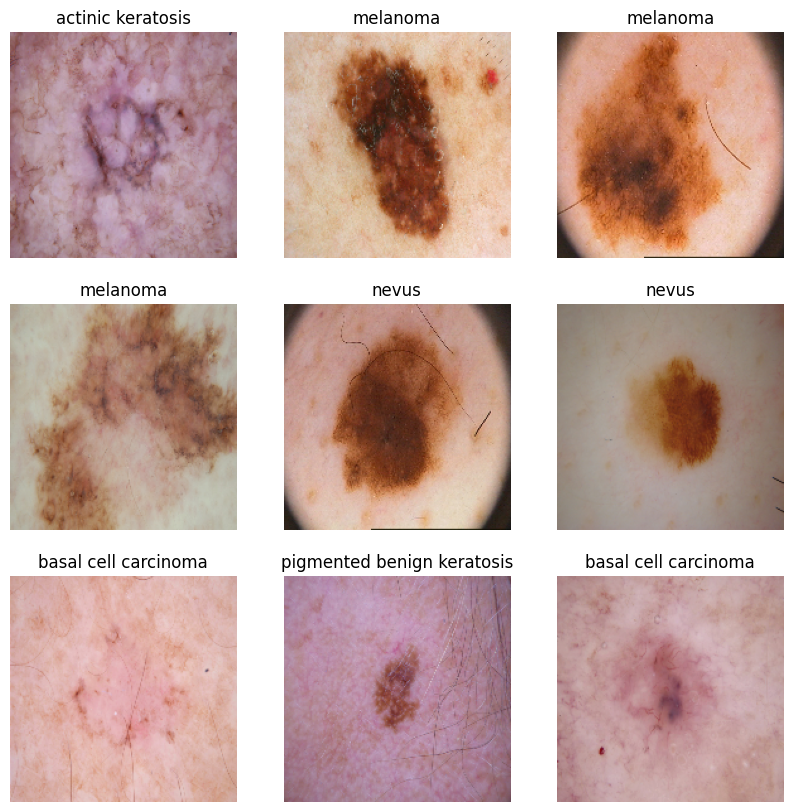

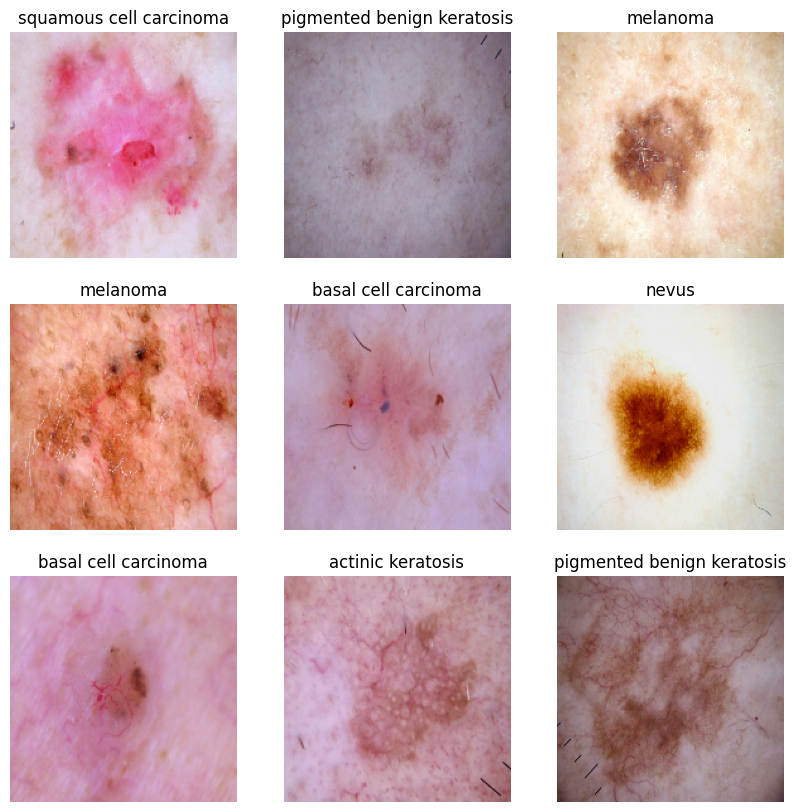

In [11]:
class_names = train_ds.class_names
print('{} classes: {}'.format(len(class_names), class_names))

def plot_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

plot_images(train_ds)
plot_images(val_ds)

In [12]:
for image_batch, label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break


(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

- `cache()` keeps the images in memory after they're loaded off disk during the first epoch, which ensures the dataset does not become a bottleneck while training the model. 

- `shuffle(1000)` randomizes the order of the examples in the dataset, which is important to prevent the model from learning unintended artifacts from the data. The argument to `shuffle` represents the buffer size; a larger buffer size means better shuffling but increased memory usage and startup delay.

- `prefetch(buffer_size=AUTOTUNE)` overlaps data preprocessing and model execution while training. It fetches batches of data in the background while the model is training. The `buffer_size` parameter determines the number of batches to prefetch. If set to `AUTOTUNE`, TensorFlow will automatically choose an optimal number.


In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))



0.19313727 0.9388887


- This creates a normalization layer that rescales pixel values in the image. Images typically have pixel values in the range 0-255, but a neural network prefers to work with small input values. Therefore, we rescale each pixel value to the range 0-1 by dividing by 255.

- After nomalization layer applied to the images, the pixel values are between 0 and 1.

#### 5. Model Building and Training

In [15]:
num_classes = class_names.__len__()

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_height, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 64800)             0

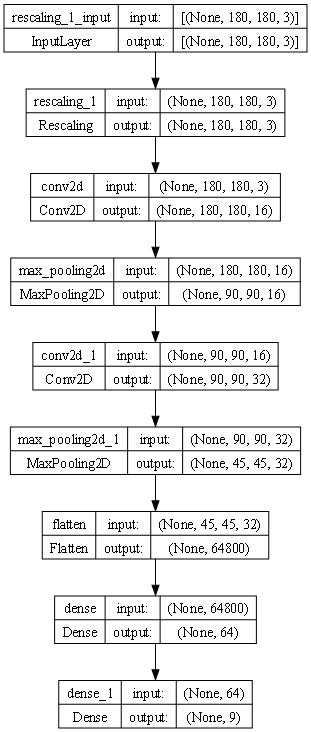

In [18]:
tf.keras.utils.plot_model(model = model , rankdir="TB", dpi=72, show_shapes=True)

- Input Layer: The model takes an input of images with the shape (height, width, color channels), specifically (180, 180, 3) as per the input_shape in the Rescaling layer. This corresponds to color images of 180 by 180 pixels.

- Rescaling Layer: The first layer in the model rescales pixel values from a range of 0-255 to 0-1 by multiplying them by 1./255. This normalization step is crucial for helping the model to converge during training.

- First Convolutional Layer (Conv2D): The model applies a convolution operation with 16 filters of size 3x3, using 'same' padding to keep the output size equal to the input size, and ReLU (rectified linear unit) activation. This layer is designed to detect basic features such as edges and simple textures.

- First MaxPooling Layer (MaxPooling2D): Following the convolution, the network applies a 2x2 max pooling operation, which reduces the spatial dimensions of the feature maps by half, resulting in output dimensions of (90, 90, 16). This layer helps reduce computation and controls overfitting by abstracting the features.

- Second Convolutional Layer (Conv2D): Another convolutional layer with 32 filters of size 3x3 is used, again with 'same' padding and ReLU activation. This layer captures more complex features.

- Second MaxPooling Layer (MaxPooling2D): The second max pooling operation further reduces the spatial dimensions, creating an output of (45, 45, 32). It continues the process of abstracting features and reducing the feature map size.

- Flattening Layer (Flatten): The flattened layer converts the 2D feature maps into a 1D array without losing any information from the output of the previous max pooling layer. This is necessary to transition from the convolutional layers to the fully connected layers.

- First Dense Layer: A dense layer with 64 neurons and ReLU activation follows, which allows the network to learn non-linear combinations of the high-level features extracted by the convolutional layers.

- Output Dense Layer: The final layer in the network is a dense layer with a number of neurons equal to the number of classes (num_classes) to be predicted. 

In [19]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 15s 253ms/step - loss: 2.4777 - accuracy: 0.1959 - val_loss: 2.0631 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 11s 200ms/step - loss: 1.9393 - accuracy: 0.2896 - val_loss: 1.8727 - val_accuracy: 0.3691
Epoch 3/20
56/56 [==============================] - 11s 200ms/step - loss: 1.7400 - accuracy: 0.3711 - val_loss: 1.6374 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 11s 196ms/step - loss: 1.5088 - accuracy: 0.4732 - val_loss: 1.5078 - val_accuracy: 0.4698
Epoch 5/20
56/56 [==============================] - 11s 205ms/step - loss: 1.3461 - accuracy: 0.5430 - val_loss: 1.5994 - val_accuracy: 0.4474
Epoch 6/20
56/56 [==============================] - 12s 208ms/step - loss: 1.2106 - accuracy: 0.5759 - val_loss: 1.4859 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 11s 198ms/step - loss: 1.0970 - accuracy: 0.6083 - val_loss: 1.4724 - val_accuracy: 0.51

Now lets plot the model accuracy for train and validation dataset.

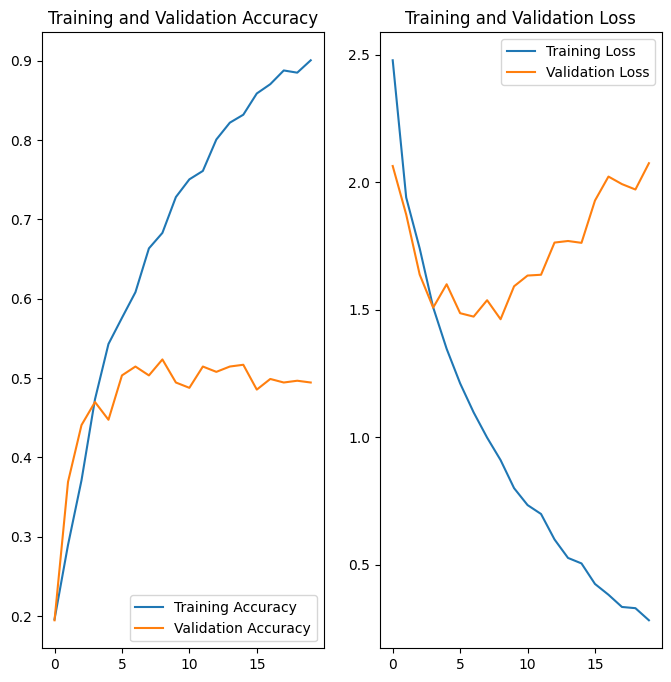

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From above graph we can come to following conclusions

- These graphs suggest that while the model is learning and improving its performance on the training set (as shown by increasing accuracy and decreasing loss), it's not generalizing well to the validation set beyond a certain point. This is evident from the stagnating validation accuracy and the increasing validation loss as the number of epochs grows. 

- To address this, one might consider implementing techniques to reduce overfitting, such as adding dropout layers, applying data augmentation, or using regularization methods.

#### 6. Data Augumentation

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(image_height, 
                                                              image_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

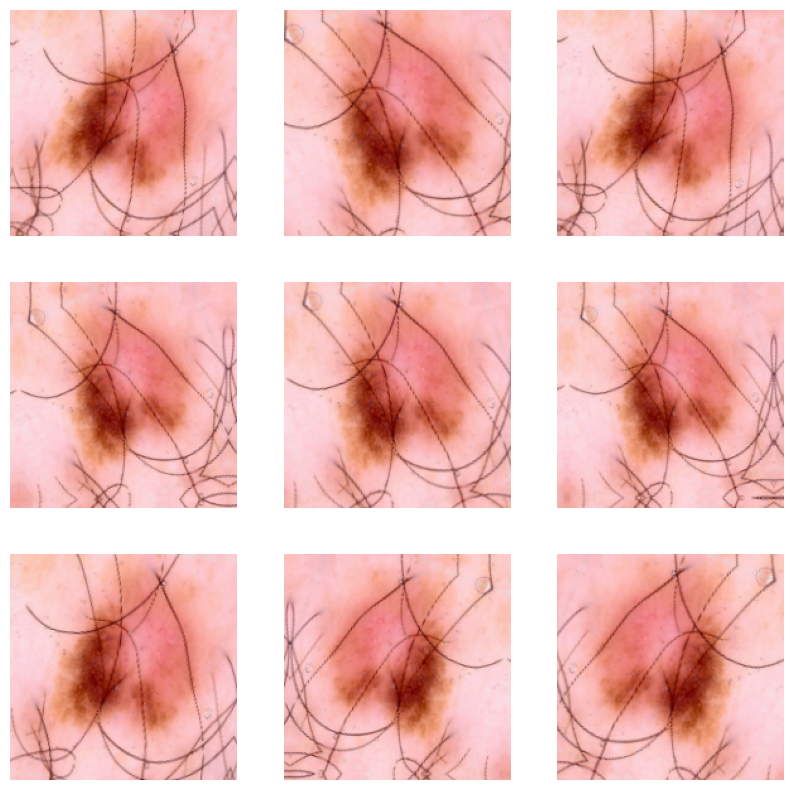

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### 7. Model Building using Augumented Data

In [25]:
aug_model = Sequential([
      data_augmentation,
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(num_classes)])

In [26]:
aug_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

aug_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

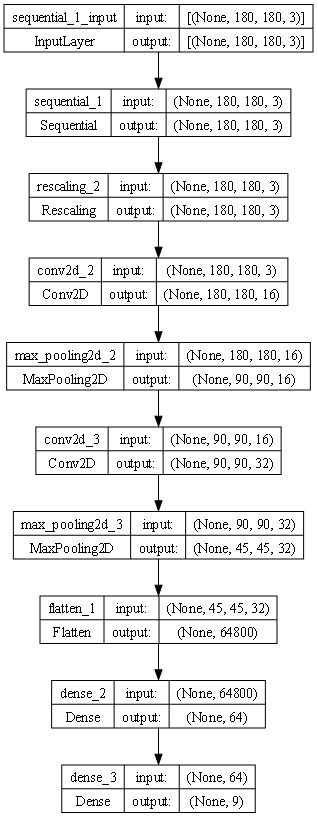

In [27]:
tf.keras.utils.plot_model(model = aug_model , rankdir="TB", dpi=72, show_shapes=True)

In [28]:
history = aug_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 15s 245ms/step - loss: 2.0960 - accuracy: 0.2372 - val_loss: 1.8236 - val_accuracy: 0.3177
Epoch 2/20
56/56 [==============================] - 14s 253ms/step - loss: 1.7479 - accuracy: 0.3499 - val_loss: 1.7372 - val_accuracy: 0.3535
Epoch 3/20
56/56 [==============================] - 14s 247ms/step - loss: 1.5826 - accuracy: 0.4442 - val_loss: 1.4897 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 14s 245ms/step - loss: 1.5547 - accuracy: 0.4358 - val_loss: 1.5693 - val_accuracy: 0.4139
Epoch 5/20
56/56 [==============================] - 13s 240ms/step - loss: 1.4391 - accuracy: 0.4894 - val_loss: 1.4146 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 14s 246ms/step - loss: 1.4143 - accuracy: 0.5017 - val_loss: 1.5329 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 13s 240ms/step - loss: 1.3393 - accuracy: 0.5251 - val_loss: 1.3917 - val_accuracy: 0.4966

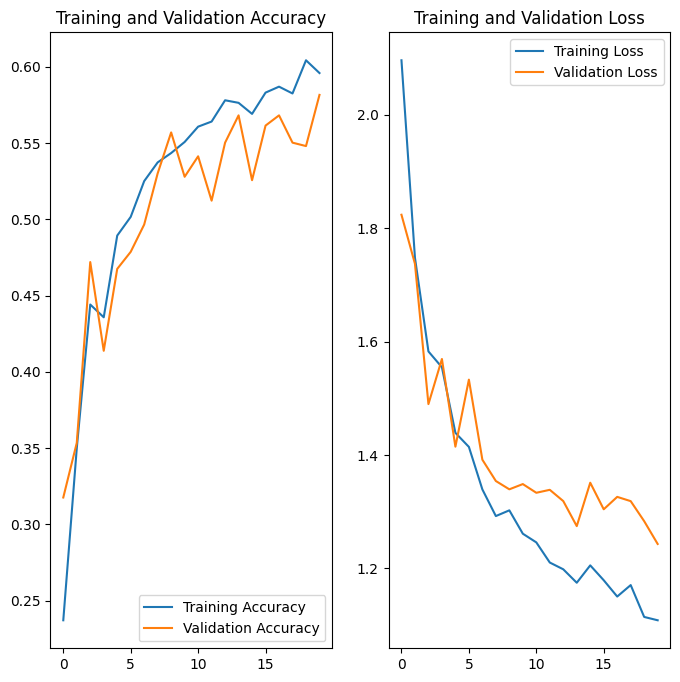

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 - These graphs suggest the model is learning and improving but also hint at some overfitting, as evidenced by the higher volatility in validation accuracy and the slight uptick in validation loss. 
 
 - The model's ability to generalize might be improved with more data, regularization, or adjusting the complexity of the model.

#### 8. Class Distribution

In [33]:
path_list = [x for x in glob(os.path.join(train_dir, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(train_dir, '*', '*.jpg'))]
len(path_list)

2239

In [34]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis
...,...,...
2234,Train\vascular lesion\ISIC_0033844.jpg,vascular lesion
2235,Train\vascular lesion\ISIC_0033969.jpg,vascular lesion
2236,Train\vascular lesion\ISIC_0033991.jpg,vascular lesion
2237,Train\vascular lesion\ISIC_0034196.jpg,vascular lesion


In [ ]:
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()